### Libraries

In [2]:
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader,Subset,SubsetRandomSampler
import torch.nn.functional as F
import matplotlib.pyplot as plt

### MNIST Data

In [3]:
custom_transform = transforms.Compose([transforms.ToTensor()])

train_data=datasets.MNIST(root='./data', train=True, download=True,transform=custom_transform)
test_data=datasets.MNIST(root='./data', train=False, download=True,transform=custom_transform)

### Training and Test Set Size

In [12]:
print("Training set size:",train_data.data.shape)
print("Training set size:",train_data.data.shape)

Training set size: torch.Size([60000, 28, 28])
Training set size: torch.Size([60000, 28, 28])


In [4]:
img, label = train_data[0]
img2 = train_data.data[0]
img.shape, img2.shape

(torch.Size([1, 28, 28]), torch.Size([28, 28]))

### Let's visualize it!!!

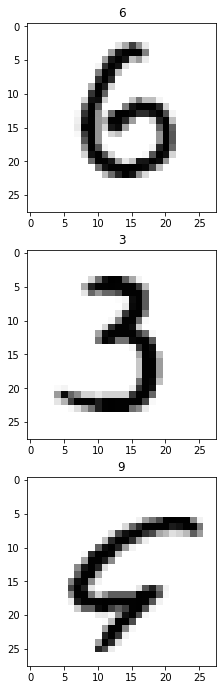

In [4]:
figure = plt.figure(figsize=(16,16))
for i in range(1,4):
    idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[idx]
    figure.add_subplot(4, 1, i)
    plt.title(label)
    plt.imshow(img.reshape(28,28), cmap="binary")
plt.show()

### We have a very large dataset. Use it to create a subset (optional).

In [5]:
shuffle_idx = torch.randperm(len(train_data), dtype=torch.long)[:6000]
train_data=Subset(train_data,shuffle_idx)
test_data=Subset(test_data,shuffle_idx)

## Dataloader

In [6]:
train_dataloader = DataLoader(train_data, batch_size=100, shuffle=True)
test_dataloader = DataLoader(train_data, batch_size=600, shuffle=True)

In [7]:
for images, labels in train_dataloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([100, 1, 28, 28])
Image label dimensions: torch.Size([100])


## Model

In [8]:
class NNnetwork(torch.nn.Module):
    def __init__(self, num_features, num_classes,
                 num_hidden1, num_hidden2):
        super(NNnetwork, self).__init__()
        self.linear1 = torch.nn.Linear(num_features, num_hidden1)
        self.linear2 = torch.nn.Linear(num_hidden1, num_hidden2)
        self.linear3 = torch.nn.Linear(num_hidden2, num_classes)
        
    def forward(self, x):
        out1 = self.linear1(x)
        out2 = F.relu(out1)
        out3 = self.linear2(out2)
        out4 = F.relu(out3)
        logits = self.linear3(out4) 
        probs = F.softmax(logits, dim=1)
        return logits,probs

def train(model, dataloader, num_epochs,
          learning_rate=0.1):
    
    cost = []
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    for e in range(num_epochs):
        model.train()
        for  x, y in dataloader:

            logits,probs = model(x.reshape(-1,28*28))
            
            loss = F.cross_entropy(logits, y.reshape(-1,))
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
        model.eval()
        with torch.no_grad():
            epoch_loss=0
            for  x, y in dataloader:
                logits,probs = model(x.reshape(-1,28*28))
                batch_loss = F.cross_entropy(logits, y.reshape(-1,))
                epoch_loss = epoch_loss + batch_loss
            cost.append(epoch_loss)

    return cost

def test(model,dataloader):
    with torch.no_grad():
        correct_pred,num_example=0,0
        for  x, y in dataloader:
            logits, probs = model(x.reshape(-1,28*28))
            _, predicted_labels = torch.max(probs, 1)
            correct_batch_pred = (predicted_labels == y).sum()
            correct_pred = correct_pred + correct_batch_pred
            num_example = num_example + predicted_labels.size(0)
    accuracy=(correct_pred/num_example)*100
    return accuracy

Test set accuracy: tensor(99.9500)
Train set accuracy: tensor(99.9500)


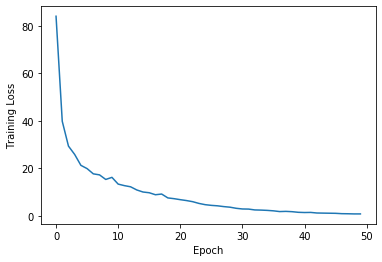

In [10]:
model = NNnetwork(num_features=28*28, num_classes=10, num_hidden1=250, num_hidden2=50)
cost=train(model, train_dataloader, num_epochs=50)
test_accuracy=test(model, test_dataloader)
train_accuracy=test(model, train_dataloader)
plt.plot(cost)
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
print("Test set accuracy:",test_accuracy)
print("Train set accuracy:",train_accuracy)